In [1]:
from tensorflow.keras.models import Model


2022-04-11 01:24:22.009886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 01:24:22.009920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.layers import Input,LSTM, Dense

In [3]:
import numpy as np

In [4]:
batchsize=64

In [5]:
epochs=100

In [6]:
latentdim=256

In [7]:
numsamples=10000

In [8]:
datapath='spa.txt'

In [9]:
inputtexts=[]

In [10]:
targettexts=[]

In [11]:
inputcharacters=set()

In [12]:
targetcharacters=set()

In [13]:
with open(datapath,'r',encoding='utf-8') as f:
    lines=f.read().split('\n')
    

In [14]:
for line in lines[:min(numsamples,len(lines)-1)]:
    inputtext,targettext,_=line.split('\t')
    targettext='\t'+targettext+'\n'
    inputtexts.append(inputtext)
    targettexts.append(targettext)
    for char in inputtext:
        if char not in inputcharacters:
            inputcharacters.add(char)
    for char in targettext:
        if char not in targetcharacters:
            targetcharacters.add(char)        

In [15]:
len(targetcharacters)

84

In [16]:
inputcharacters=sorted(list(inputcharacters))

In [17]:
targetcharacters=sorted(list(targetcharacters))

In [18]:
len(inputtexts)

10000

In [19]:
numencodertokens=len(inputcharacters)
numdecodertokens=len(targetcharacters)

In [20]:
maxencoderseqlength=max([len(txt) for txt in inputtexts])

In [21]:
maxdecoderseqlength=max([len(txt) for txt in targettexts])

In [22]:
maxencoderseqlength

16

In [23]:
maxdecoderseqlength

42

In [24]:
inputtokenindex=dict([(char,i) for i ,char in enumerate(inputcharacters)])

In [25]:
targettokenindex=dict([(char,i) for i ,char in enumerate(targetcharacters)])

In [26]:
inputtexts

['Go.',
 'Go.',
 'Go.',
 'Go.',
 'Hi.',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run.',
 'Who?',
 'Wow!',
 'Duck!',
 'Fire!',
 'Fire!',
 'Fire!',
 'Help!',
 'Help!',
 'Help!',
 'Jump!',
 'Jump.',
 'Jump.',
 'Stay.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait!',
 'Wait.',
 'Wait.',
 'Go on.',
 'Go on.',
 'Hello!',
 'Hurry!',
 'Hurry!',
 'Hurry!',
 'I hid.',
 'I hid.',
 'I hid.',
 'I hid.',
 'I ran.',
 'I ran.',
 'I try.',
 'I won!',
 'Oh no!',
 'Relax.',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Shoot!',
 'Smile.',
 'Sorry?',
 'Attack!',
 'Attack!',
 'Attack!',
 'Attack!',
 'Attack!',
 'Get up.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Go now.',
 'Got it!',
 'Got it?',
 'Got it?',
 'He ran.',
 'He ran.',
 'Hop in.',
 'Hug me.',
 'I care.',
 'I fell.',
 'I fled.',
 'I fled.',
 'I fled.',
 'I fled.',
 'I know.',
 'I know.',
 'I left.',
 'I lied.',
 'I lost.',
 'I paid.',
 'I quit.',
 'I quit.',
 'I quit.',
 'I sang.'

In [27]:
encoderinputdata=np.zeros((len(inputtexts),maxencoderseqlength,len(inputcharacters)),dtype='float32')

In [28]:
decoderinputdata=np.zeros((len(inputtexts),maxdecoderseqlength,len(targetcharacters)),dtype='float32')

In [29]:
decodertargetdata=np.zeros((len(inputtexts),maxdecoderseqlength,len(targetcharacters)),dtype='float32')

In [30]:
for i ,(inputtext,targettext) in enumerate(zip(inputtexts,targettexts)):
    for t,char in enumerate(inputtext):
        encoderinputdata[i,t,inputtokenindex[char]]=1.
    encoderinputdata[i,t+1:,inputtokenindex[' ']]=1.
    for t,char in enumerate(targettext):
        decoderinputdata[i,t,targettokenindex[char]]=1.
        if t>0:
            decodertargetdata[i,t-1,targettokenindex[char]]=1.
    decoderinputdata[i,t+1:,targettokenindex[' ']]=1.
    decodertargetdata[i,t:,targettokenindex[' ']]=1.

In [31]:
encoderinputdata.shape

(10000, 16, 69)

In [32]:
decoderinputdata.shape

(10000, 42, 84)

In [33]:
decodertargetdata.shape

(10000, 42, 84)

In [34]:
encoderinputs=Input(shape=(None,numencodertokens))

In [35]:
encoder=LSTM(latentdim,return_state=True)

2022-04-11 01:24:26.932075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-11 01:24:26.932141: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 01:24:26.932192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (harshit-Lenovo-IdeaPad-S145-15IWL): /proc/driver/nvidia/version does not exist
2022-04-11 01:24:26.933307: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
encoderoutputs,stateh,statec=encoder(encoderinputs)

In [37]:
encoderstates=[stateh,statec]

In [38]:
decoderinputs=Input(shape=(None,numdecodertokens))

In [39]:
decoderlstm=LSTM(latentdim,return_sequences=True,return_state=True)

In [40]:
decoderoutputs,_,_=decoderlstm(decoderinputs,initial_state=encoderstates)

In [41]:
decoderdense=Dense(numdecodertokens,activation='softmax')

In [42]:
decoderoutputs=decoderdense(decoderoutputs)

In [43]:
m=Model([encoderinputs,decoderinputs],decoderoutputs)

In [44]:
m.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
m.fit([encoderinputdata,decoderinputdata],decodertargetdata,batch_size=batchsize,epochs=epochs,validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 27s 178ms/step - loss: 1.3940 - accuracy: 0.6643 - val_loss: 1.3360 - val_accuracy: 0.6381
Epoch 2/100
125/125 [==============================] - 21s 168ms/step - loss: 1.0349 - accuracy: 0.7171 - val_loss: 1.0658 - val_accuracy: 0.6927
Epoch 3/100
125/125 [==============================] - 21s 169ms/step - loss: 0.8538 - accuracy: 0.7541 - val_loss: 0.9453 - val_accuracy: 0.7138
Epoch 4/100
125/125 [==============================] - 21s 170ms/step - loss: 0.7665 - accuracy: 0.7713 - val_loss: 0.8786 - val_accuracy: 0.7376
Epoch 5/100
125/125 [==============================] - 21s 172ms/step - loss: 0.7092 - accuracy: 0.7868 - val_loss: 0.8140 - val_accuracy: 0.7569
Epoch 6/100
125/125 [==============================] - 23s 188ms/step - loss: 0.6670 - accuracy: 0.7991 - val_loss: 0.7679 - val_accuracy: 0.7699
Epoch 7/100
125/125 [==============================] - 28s 223ms/step - loss: 0.6308 - accuracy: 0.8097 - val_loss: 0.7367 -

Epoch 57/100
125/125 [==============================] - 26s 210ms/step - loss: 0.1025 - accuracy: 0.9688 - val_loss: 0.8779 - val_accuracy: 0.8215
Epoch 58/100
125/125 [==============================] - 26s 210ms/step - loss: 0.0991 - accuracy: 0.9703 - val_loss: 0.8841 - val_accuracy: 0.8208
Epoch 59/100
125/125 [==============================] - 26s 211ms/step - loss: 0.0970 - accuracy: 0.9709 - val_loss: 0.8962 - val_accuracy: 0.8206
Epoch 60/100
125/125 [==============================] - 26s 209ms/step - loss: 0.0941 - accuracy: 0.9715 - val_loss: 0.8992 - val_accuracy: 0.8205
Epoch 61/100
125/125 [==============================] - 24s 194ms/step - loss: 0.0909 - accuracy: 0.9724 - val_loss: 0.9098 - val_accuracy: 0.8208
Epoch 62/100
125/125 [==============================] - 21s 170ms/step - loss: 0.0889 - accuracy: 0.9731 - val_loss: 0.9194 - val_accuracy: 0.8209
Epoch 63/100
125/125 [==============================] - 29s 228ms/step - loss: 0.0866 - accuracy: 0.9736 - val_loss: 0

In [60]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 69)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 84)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        333824      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

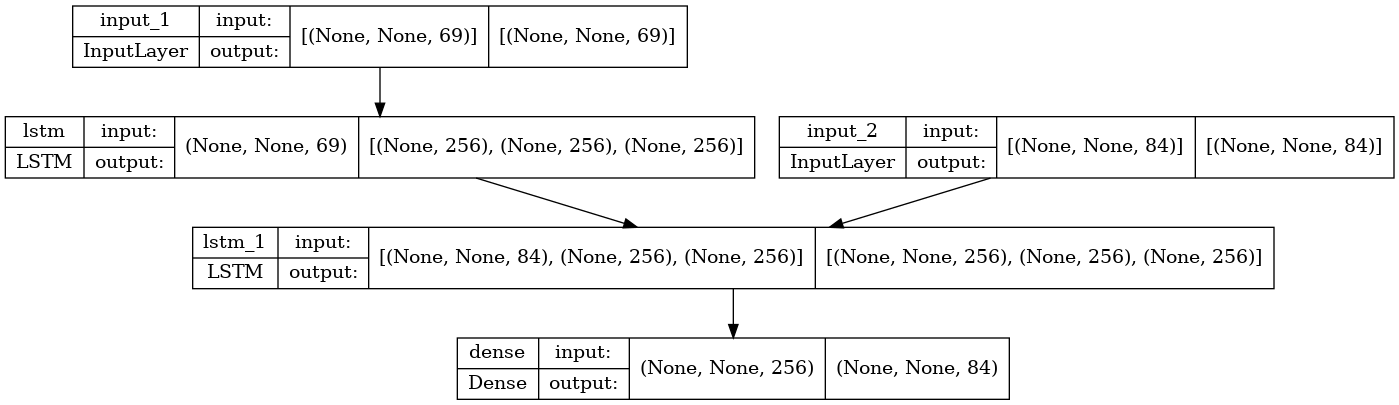

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.plot_model(m, "my_first_model_with_shape_info.png", show_shapes=True)

In [59]:
m.save('traslationmodel')

2022-04-11 02:08:15.734616: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: traslationmodel/assets


INFO:tensorflow:Assets written to: traslationmodel/assets


In [46]:
encodemodel=Model(encoderinputs,encoderstates)

In [47]:
decoderstateinputh=Input(shape=(latentdim,))

In [48]:
decoderstateinputc=Input(shape=(latentdim,))

In [49]:
decoderstateinputs=[decoderstateinputc,decoderstateinputh]

In [50]:
decoderoutputs,stateh,statec=decoderlstm(decoderinputs,initial_state=decoderstateinputs)

In [51]:
decoderstates=[stateh,statec]

In [52]:
decoderoutputs=decoderdense(decoderoutputs)

In [53]:
decodermodel=Model(
    [decoderinputs]+decoderstateinputs,
    [decoderoutputs]+decoderstates)

In [54]:
reverseinputcharindex=dict((i,char) for char,i in inputtokenindex.items())

In [55]:
reversetargetcharindex=dict((i,char) for char,i in targettokenindex.items())

In [56]:
def decode_sequence(inputseq):
    statesvalue=encodemodel.predict(inputseq)
    targetseq=np.zeros((1,1,numdecodertokens))
    targetseq[0,0,targettokenindex['\t']]=1
    stopcondition=False
    decodedsentence=''
    while not stopcondition:
        outputtokens,h,c=decodermodel.predict([targetseq]+statesvalue)
        sampledtokenindex=np.argmax(outputtokens[0,-1,:])
        sampleschar=reversetargetcharindex[sampledtokenindex]
        decodedsentence+=sampleschar
        if(sampleschar=='\n'or len(decodedsentence)>maxdecoderseqlength):
            stopcondition=True
        targetseq=np.zeros((1,1,numdecodertokens))
        targetseq[0,0,sampledtokenindex]=1
        statesvalue=[h,c]
    return decodedsentence

In [57]:
for seqindex in range(100,200):
    inputseq=encoderinputdata[seqindex:seqindex+1]
    decodedsentence=decode_sequence(inputseq)
    print('-')
    print('INPUT:',inputtexts[seqindex])
    print('DECODED:',decodedsentence)

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: No way!
DECODED: ¡De eso nada!

-
INPUT: Really?
DECODED: ¿La verdad?

-
INPUT: Really?
DECODED: ¿La verdad?

-
INPUT: Thanks!
DECODED: ¡Gracias!

-
INPUT: Thanks.
DECODED: Gracias.

-
INPUT: Thanks.
DECODED: Gracias.

-
INPUT: Try it.
DECODED: Pruébalo.

-
INPUT: Try me.
DECODED: A que sí, ya verás.

-
INPUT: We ate.
DECODED: Comimos.

-
INPUT: We try.
DECODED: Lo procuramos.

-
INPUT: We won.
DECODED: Ganamos.

-
INPUT: Why me?
DECODED: ¿Por qué yo?

-
INPUT: Ask Tom.
DECODED: Pregúntale a Tom.

-
INPUT: Ask him.
DECODED: Pregúntale.

-
INPUT: Awesome!
DECODED: ¡Órale!

-
INPUT: Be calm.
DECODED: Mantente en calm